### Building a model to differentiate between noise, muons and electrons from scratch

In this notebook, we will build a convolutional neural network to classify a signal as electron, muon or noise. Therefore, we are facing a multiclass classification problem: electron, muon or noise. This is the reason why we will have just one neuron in the output layer with softmax activation.

First we import the data stored in a file called `eVSmuVSn_noisy1.npz` composed of two variables: 'data' for the numpy arrays with energy or noise, and 'labels' where 1 stands for electron signal, 2 for muon signal and 0 for noise.

* [First model: data with class_weights](#First-model:-data-with-class_weights)
* [Second model: Under/oversampling data](#Second-model:-Under/oversampling-data)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
loaded = np.load('/Users/Silvia/Desktop/TFM/e_VS_mu_VS_n/eVSmuVSn_1.npz')
X = loaded['data']
y = loaded['labels']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
print(X_train.shape)

(5143, 296, 286)


In [6]:
from sklearn import preprocessing

aux_train = X_train.reshape((X_train.shape[0], X_train.shape[1]* X_train.shape[2]))
aux_test = X_test.reshape((X_test.shape[0], X_test.shape[1]* X_test.shape[2]))

scaler = preprocessing.StandardScaler().fit(aux_train)

X_trainr = scaler.transform(aux_train)

X_testr = scaler.transform(aux_test)

print(X_trainr.shape, X_testr.shape)

(5143, 84656) (1715, 84656)


In [7]:
X_train = X_trainr.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

print(X_train.shape)

(5143, 296, 286, 1)


In [8]:
X_test = X_testr.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(X_test.shape)

(1715, 296, 286, 1)


In [2]:
import keras

Using TensorFlow backend.


In [3]:
from keras import layers, models, optimizers

### First model: data with class_weights

In [4]:
window_y, window_x = 296,286

In [12]:
model_v1 = models.Sequential()
model_v1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))

model_v1.add(layers.Flatten())
model_v1.add(layers.Dense(units= 2050, activation='relu'))
model_v1.add(layers.Dense(units= 512, activation='relu'))
model_v1.add(layers.Dense(units= 3, activation='softmax'))
model_v1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 294, 284, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 142, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 140, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 70, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 68, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 34, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 32, 128)      

In [13]:
model_v1.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [14]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [15]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
model_v1.fit(X_train, one_hot_train_labels, class_weight=class_weights, epochs= 15, validation_split = 0.2)

Train on 4114 samples, validate on 1029 samples
Epoch 1/15
4114/4114 [==============================] - 333s 81ms/step - loss: 0.6025 - acc: 0.7710 - val_loss: 0.4727 - val_acc: 0.7988
Epoch 2/15
4114/4114 [==============================] - 344s 84ms/step - loss: 0.3301 - acc: 0.8576 - val_loss: 0.3881 - val_acc: 0.8348
Epoch 3/15
4114/4114 [==============================] - 341s 83ms/step - loss: 0.2169 - acc: 0.9115 - val_loss: 0.4541 - val_acc: 0.8222
Epoch 4/15
4114/4114 [==============================] - 345s 84ms/step - loss: 0.1454 - acc: 0.9434 - val_loss: 0.5035 - val_acc: 0.8426
Epoch 5/15
4114/4114 [==============================] - 349s 85ms/step - loss: 0.0935 - acc: 0.9623 - val_loss: 0.6573 - val_acc: 0.8251
Epoch 6/15
4114/4114 [==============================] - 349s 85ms/step - loss: 0.0602 - acc: 0.9767 - val_loss: 0.7722 - val_acc: 0.8047
Epoch 7/15
4114/4114 [==============================] - 346s 84ms/step - loss: 0.0465 - acc: 0.9849 - val_loss: 0.9738 - val_acc: 

In [5]:
import matplotlib.pyplot as plt

In [6]:
#https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [32]:
model_v1.save('model_e_mu_or_n_v1.h5')

In [16]:
loss, acc = model_v1.evaluate(X_test, one_hot_test_labels)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

1715/1715 [==============================] - 34s 20ms/step
Accuracy with the model: 80.64%


In [17]:
y_predicted1 = model_v1.predict(X_test)

In [18]:
y_predicted1

array([[1.0000000e+00, 5.8218351e-08, 3.0675560e-13],
       [4.2868528e-11, 9.9999774e-01, 2.3073464e-06],
       [1.0000000e+00, 8.9619569e-24, 4.3206611e-32],
       ...,
       [1.0000000e+00, 5.9536274e-22, 1.7700027e-28],
       [1.2076167e-29, 1.0000000e+00, 7.3066327e-12],
       [9.9999940e-01, 5.9725807e-08, 5.1227795e-07]], dtype=float32)

In [19]:
y_predicted_1 = np.argmax(y_predicted1, axis=1)

In [20]:
y_predicted_1

array([0, 1, 0, ..., 0, 1, 0])

In [7]:
import matplotlib.pyplot as plt

In [8]:
from sklearn.metrics import confusion_matrix

In [36]:
conf=confusion_matrix(y_test, y_predicted_1, labels = list([0,1,2]))
conf

array([[851,  18,   0],
       [ 90, 520,  37],
       [ 30, 157,  12]])

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.grid(b=False)
    plt.xlim(-0.5, 2.5)
    plt.ylim(2.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

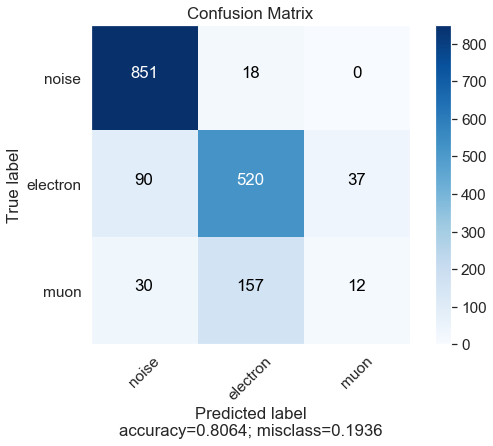

In [51]:
plot_confusion_matrix(cm           = conf, 
                      normalize    = False,
                      target_names = ['noise', 'electron', 'muon'],
                      title        = "Confusion Matrix")


In [52]:
plt.savefig('conf1.png')

<Figure size 432x288 with 0 Axes>

### Second model: Under/oversampling data

In [3]:
loaded = np.load('/Users/Silvia/Desktop/TFM/e_VS_mu_VS_n/eVSmuVSn_tr1.npz')
X_train = loaded['data']
y_train = loaded['labels']

In [4]:
print(X_train.shape, y_train.shape)

(5943, 296, 286) (5943,)


In [5]:
loaded = np.load('/Users/Silvia/Desktop/TFM/e_VS_mu_VS_n/eVSmuVSn_te1.npz')
X_test = loaded['data_test']
y_test = loaded['labels_test']

In [13]:
print(X_test.shape, y_test.shape)

(1715, 296, 286) (1715,)


In [14]:
from sklearn import preprocessing

aux_train = X_train.reshape((X_train.shape[0], X_train.shape[1]* X_train.shape[2]))
aux_test = X_test.reshape((X_test.shape[0], X_test.shape[1]* X_test.shape[2]))

scaler = preprocessing.StandardScaler().fit(aux_train)

X_trainr = scaler.transform(aux_train)

X_testr = scaler.transform(aux_test)

print(X_trainr.shape, X_testr.shape)

(5943, 84656) (1715, 84656)


In [15]:
X_train = X_trainr.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

print(X_train.shape)

(5943, 296, 286, 1)


In [16]:
X_test = X_testr.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(X_test.shape)

(1715, 296, 286, 1)


In [17]:
window_y, window_x = 296,286

In [18]:
model_v2 = models.Sequential()
model_v2.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))

model_v2.add(layers.Flatten())
model_v2.add(layers.Dense(units= 2050, activation='relu'))
model_v2.add(layers.Dense(units= 512, activation='relu'))
model_v2.add(layers.Dense(units= 3, activation='softmax'))
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 294, 284, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 142, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 140, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 70, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 68, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 34, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 32, 128)      

In [19]:
model_v2.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [20]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [21]:
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
historyv2 = model_v2.fit(X_train, one_hot_train_labels,  epochs= 20, validation_split = 0.2)#,class_weight=class_weights,)

Train on 4754 samples, validate on 1189 samples
Epoch 1/20
4754/4754 [==============================] - 394s 83ms/step - loss: 0.5922 - acc: 0.7430 - val_loss: 0.9915 - val_acc: 0.3263
Epoch 2/20
4754/4754 [==============================] - 387s 81ms/step - loss: 0.3308 - acc: 0.8540 - val_loss: 1.0228 - val_acc: 0.3516
Epoch 3/20
4754/4754 [==============================] - 381s 80ms/step - loss: 0.2213 - acc: 0.9060 - val_loss: 0.3605 - val_acc: 0.8183
Epoch 4/20
4754/4754 [==============================] - 403s 85ms/step - loss: 0.1405 - acc: 0.9468 - val_loss: 0.2453 - val_acc: 0.9008
Epoch 5/20
4754/4754 [==============================] - 660s 139ms/step - loss: 0.0931 - acc: 0.9638 - val_loss: 0.0896 - val_acc: 0.9731
Epoch 6/20
4754/4754 [==============================] - 392s 82ms/step - loss: 0.0592 - acc: 0.9800 - val_loss: 0.1195 - val_acc: 0.9546
Epoch 7/20
4754/4754 [==============================] - 361s 76ms/step - loss: 0.0417 - acc: 0.9870 - val_loss: 0.0764 - val_acc:

In [16]:
import matplotlib.pyplot as plt

In [22]:
model_v2.save('model_e_mu_or_n_v3.h5')

In [23]:
loss, acc = model_v2.evaluate(X_test, one_hot_test_labels)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

1715/1715 [==============================] - 39s 23ms/step
Accuracy with the model: 79.36%


In [24]:
y_predicted2 = model_v2.predict(X_test)

In [25]:
y_predicted_2 = np.argmax(y_predicted2, axis=1)

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
conf=confusion_matrix(y_test, y_predicted_2, labels = list([0,1,2]))

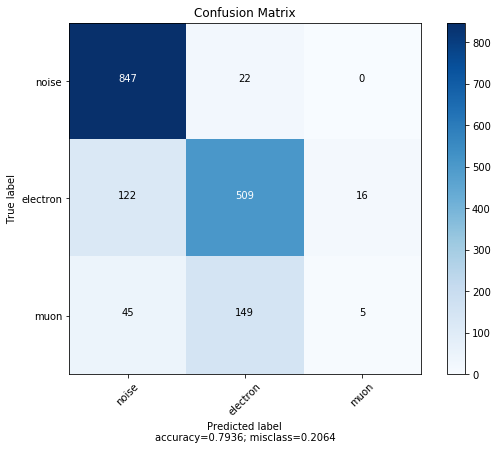

In [28]:
plot_confusion_matrix(cm           = conf, 
                      normalize    = False,
                      target_names = ['noise', 'electron', 'muon'],
                      title        = "Confusion Matrix")

In [25]:
plt.savefig('conf2.png')

<Figure size 432x288 with 0 Axes>

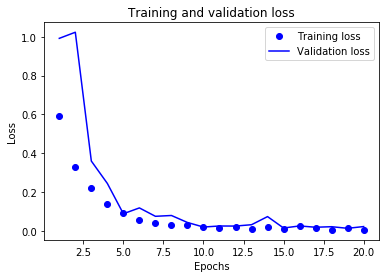

In [29]:
history_n2 = historyv2.history
loss_values_n2 = history_n2['loss']
val_loss_values_n2 = history_n2['val_loss']
epochs_n2 = range(1, len(loss_values_n2) + 1)
plt.plot(epochs_n2, loss_values_n2, 'bo', label='Training loss')
plt.plot(epochs_n2, val_loss_values_n2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
plt.savefig('hist2.png')

<Figure size 432x288 with 0 Axes>

In [30]:
from sklearn.metrics import classification_report
target_names = ['noise', 'electron', 'muon']
print(classification_report(y_test, y_predicted_2, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.84      0.97      0.90       869
    electron       0.75      0.79      0.77       647
        muon       0.24      0.03      0.05       199

    accuracy                           0.79      1715
   macro avg       0.61      0.60      0.57      1715
weighted avg       0.73      0.79      0.75      1715

